### Import libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:82.5% !important}</style>'))

In [2]:
import time

import numpy as np
import pandas as pd

import lightgbm as lgb
import xgboost as xgb
import catboost

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, VotingClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Paths to directories and files

In [5]:
TRAIN_DATASET_PATH = '../Competitive Data Analysis/data/train.csv'
TEST_DATASET_PATH = '../Competitive Data Analysis/data/test.csv'
BKI_PATH = '../Competitive Data Analysis/data/bki.csv'
CLIENT_PROFILE_PATH = '../Competitive Data Analysis/data/client_profile.csv'
PAYMENTS_PATH = '../Competitive Data Analysis/data/payments.csv'
APPLICATIONS_HISTORY_PATH = '../Competitive Data Analysis/data/applications_history.csv'
SUBMISSION_PATH = 'data/sample_submit.csv'
SUBMISSION_PATH2 = 'data/73450.csv'

### Loading data

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH) # - пары "заявка - целевая переменная", для этой выборки нужно собрать признаки и обучить модель;
test_df = pd.read_csv(TEST_DATASET_PATH) # - пары "заявки - прогнозное значение", для этой выборки нужно собрать признаки и построить прогнозы;
bki_df = pd.read_csv(BKI_PATH) # - данные БКИ о предыдущих кредитах клиента;
client_profile_df = pd.read_csv(CLIENT_PROFILE_PATH) # - клиентский профиль, некоторые знания, которые есть у компании о клиенте;
payments_df = pd.read_csv(PAYMENTS_PATH) # - история платежей клиента;
applications_history_df = pd.read_csv(APPLICATIONS_HISTORY_PATH) # - история предыдущих заявок клиента.
submission = pd.read_csv(SUBMISSION_PATH)
submission2 = pd.read_csv(SUBMISSION_PATH2)

### Functions

In [7]:
def cross_validation(model, X, y, cv):
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model.fit(X=x_train, y=y_train)
    
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f'Training fold {fold+1}, Test score: {score:.5f}')
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f'Test mean score: {np.mean(folds_scores):.5f}')
    return estimators, oof_preds, np.mean(folds_scores)

### Feature engineering

In [8]:
# Функция преобразования категориальных данных
le = LabelEncoder()

def categorical_engineering(df):
    for i in categorical_features:
        le.fit(df[i])
        df[i] = le.fit_transform(df[i])

In [9]:
categorical_features = bki_df.select_dtypes(include='object')
categorical_features = categorical_features.columns

categorical_engineering(bki_df)

In [10]:
# Агрегация и заполнение значений
bki_df = bki_df.groupby('APPLICATION_NUMBER').agg({'DAYS_CREDIT_ENDDATE': 'sum', 'AMT_CREDIT_SUM_DEBT': 'median'}) 

In [11]:
# Кредитный рейтинг('EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3')
numerical_features = client_profile_df.columns.values[15:18]

# Построение нового признака   
for df in [client_profile_df]:
    df['ESR_SUM'] = df[numerical_features].sum(axis=1)

In [12]:
# Объединение таблиц на основе ключа - 'APPLICATION_NUMBER'
train_df = pd.merge(train_df, client_profile_df, on='APPLICATION_NUMBER', how='left')
train_df = pd.merge(train_df, bki_df, on='APPLICATION_NUMBER', how='left')

test_df = pd.merge(test_df, client_profile_df, on='APPLICATION_NUMBER', how='left')
test_df = pd.merge(test_df, bki_df, on='APPLICATION_NUMBER', how='left')

In [13]:
def feature_engineering(df):
    # Построение новых признаков
    df['RATIO_CREDIT_TO_ANNUITY'] = df['AMOUNT_CREDIT'] / df['AMOUNT_ANNUITY']
    df['RATIO_ANNUITY_TO_SALARY'] = df['AMOUNT_ANNUITY'] / df['TOTAL_SALARY']
    df['RATIO_CREDIT_TO_SALARY'] = df['AMOUNT_CREDIT'] / df['TOTAL_SALARY']
    
    df['RATIO_ANNUITY_TO_AGE'] = df['AMOUNT_ANNUITY'] / df['AGE']
    df['RATIO_CREDIT_TO_AGE'] = df['AMOUNT_CREDIT'] / df['AGE']
    df['RATIO_SALARY_TO_AGE'] = df['TOTAL_SALARY'] / df['AGE']
    df['RATIO_SALARY_TO_EXPERIENCE'] = df['TOTAL_SALARY'] / df['DAYS_ON_LAST_JOB']
    df['RATIO_CREDIT_TO_EXPERIENCE'] = df['AMOUNT_CREDIT'] / df['DAYS_ON_LAST_JOB']
    df['RATIO_ANNUITY_TO_EXPERIENCE'] = df['AMOUNT_ANNUITY'] / df['DAYS_ON_LAST_JOB'] 

    df['RATIO_AGE_TO_EXPERIENCE'] = df['AGE'] / df['DAYS_ON_LAST_JOB']
    df['RATIO_SALARY_TO_REGION_POPULATION'] = df['TOTAL_SALARY'] * df['REGION_POPULATION']
    df['RATIO_CAR_TO_AGE'] = df['OWN_CAR_AGE'] / df['AGE']
    
    df['BAD_CLIENT'] = 0
    df.loc[((df['TOTAL_SALARY'] > df['AMOUNT_ANNUITY']) | 
            (df['EXTERNAL_SCORING_RATING_1'] <= 0.7500) | 
            (df['EXTERNAL_SCORING_RATING_2'] <= 0.7500) | 
            (df['EXTERNAL_SCORING_RATING_3'] <= 0.7500), 'BAD_CLIENT')] = 1 

    # Уменьшение количества выбросов
    df.loc[df['DAYS_ON_LAST_JOB'] >= 24500, 'DAYS_ON_LAST_JOB'] = 24500
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] >= 7, 'AMT_REQ_CREDIT_BUREAU_QRT'] = 7
    df.loc[df['RATIO_CAR_TO_AGE'] >= 0.007, 'RATIO_CAR_TO_AGE'] = 0.007

In [14]:
feature_engineering(train_df)
feature_engineering(test_df)

### Building the model

In [15]:
for c in train_df.columns:
    col_type = train_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        train_df[c] = train_df[c].astype('category')

In [16]:
for c in test_df.columns:
    col_type = test_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        test_df[c] = test_df[c].astype('category')

In [17]:
X = train_df.drop(['TARGET', 'APPLICATION_NUMBER'], axis=1)
y = train_df['TARGET'] 

In [18]:
# Корреляционная зависимость
correlation = train_df.corr()
corr_with_target = correlation['TARGET'].sort_values(ascending = False)
corr_with_target

TARGET                               1.00000
RATIO_CAR_TO_AGE                     0.05464
OWN_CAR_AGE                          0.04248
RATIO_ANNUITY_TO_AGE                 0.02615
CHILDRENS                            0.02339
RATIO_AGE_TO_EXPERIENCE              0.02222
RATIO_ANNUITY_TO_EXPERIENCE          0.02200
AMT_REQ_CREDIT_BUREAU_YEAR           0.02062
RATIO_SALARY_TO_EXPERIENCE           0.01952
RATIO_CREDIT_TO_EXPERIENCE           0.01681
RATIO_ANNUITY_TO_SALARY              0.01518
FAMILY_SIZE                          0.01302
RATIO_SALARY_TO_AGE                  0.01023
DAYS_CREDIT_ENDDATE                  0.00627
AMT_REQ_CREDIT_BUREAU_HOUR           0.00399
AMT_REQ_CREDIT_BUREAU_WEEK           0.00201
FLAG_EMAIL                           0.00070
AMT_REQ_CREDIT_BUREAU_DAY           -0.00103
RATIO_CREDIT_TO_AGE                 -0.00181
APPLICATION_NUMBER                  -0.00224
BAD_CLIENT                          -0.00239
AMT_REQ_CREDIT_BUREAU_QRT           -0.00286
AMT_CREDIT

#### LightGBM 1

In [19]:
results_lgb = []
oof_preds_lgb = np.zeros(X.shape[0])

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt', 
    'metric': 'auc',
    'max_depth': 5,
    'learning_rate': 0.05,
    'num_leaves': 32,
    'min_child_weight': 42,
    'categorical_feature': 'auto',
    'n_jobs': -1,
    'verbose': -1
}


folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_lgb = lgb.LGBMRegressor(**params, num_iterations=10000) 
    
    model_lgb.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              verbose=50, early_stopping_rounds=250) 

    train_predictions_lgb = model_lgb.predict(X_train)
    test_predictions_lgb = model_lgb.predict(X_test)
    oof_preds_lgb[test_index] = model_lgb.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_lgb)
    test_score = roc_auc_score(y_test, test_predictions_lgb)

    lr_time = (time.time() - start_time)
    results_lgb.append((fold, train_score, test_score, lr_time))

Training fold 1
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.737874	valid_1's auc: 0.734602
[100]	training's auc: 0.751591	valid_1's auc: 0.739861
[150]	training's auc: 0.76026	valid_1's auc: 0.743416
[200]	training's auc: 0.768121	valid_1's auc: 0.744194
[250]	training's auc: 0.774023	valid_1's auc: 0.744868
[300]	training's auc: 0.77996	valid_1's auc: 0.744687
[350]	training's auc: 0.785102	valid_1's auc: 0.744566
[400]	training's auc: 0.790127	valid_1's auc: 0.743615
[450]	training's auc: 0.794935	valid_1's auc: 0.743042
[500]	training's auc: 0.798892	valid_1's auc: 0.743097
Early stopping, best iteration is:
[261]	training's auc: 0.775744	valid_1's auc: 0.745166
Training fold 2
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.739545	valid_1's auc: 0.722814
[100]	training's auc: 0.752806	valid_1's auc: 0.726623
[150]	training's auc: 0.761856	valid_1's auc: 0.728894
[200]	training's auc: 0.769298	valid_1's au

[150]	training's auc: 0.761894	valid_1's auc: 0.727732
[200]	training's auc: 0.768103	valid_1's auc: 0.729859
[250]	training's auc: 0.774407	valid_1's auc: 0.730849
[300]	training's auc: 0.779414	valid_1's auc: 0.730704
[350]	training's auc: 0.784562	valid_1's auc: 0.731361
[400]	training's auc: 0.789248	valid_1's auc: 0.731177
[450]	training's auc: 0.794009	valid_1's auc: 0.731699
[500]	training's auc: 0.798755	valid_1's auc: 0.731848
[550]	training's auc: 0.802219	valid_1's auc: 0.731841
[600]	training's auc: 0.805873	valid_1's auc: 0.732569
[650]	training's auc: 0.809025	valid_1's auc: 0.731643
[700]	training's auc: 0.811816	valid_1's auc: 0.731878
[750]	training's auc: 0.814706	valid_1's auc: 0.731544
[800]	training's auc: 0.816932	valid_1's auc: 0.731245
[850]	training's auc: 0.819427	valid_1's auc: 0.731571
Early stopping, best iteration is:
[609]	training's auc: 0.806577	valid_1's auc: 0.732731
Training fold 11
Training until validation scores don't improve for 250 rounds
[50]	t

In [20]:
best_models1 = pd.DataFrame((results_lgb))
best_models1.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models1.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.77574,0.74517,3.95760
1,1,0.79261,0.73252,5.22835
2,2,0.78828,0.73403,4.98229
3,3,0.79417,0.73694,5.48029
4,4,0.76910,0.72387,3.59705
5,5,0.78924,0.71501,4.83126
6,6,0.79458,0.72754,5.57200
7,7,0.82712,0.74650,10.63835
8,8,0.78705,0.73543,5.34148
9,9,0.80658,0.73273,8.00457


In [21]:
print(f'Train mean score: {round(np.mean(best_models1.train_score), 4)}, std: {round(np.std(best_models1.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models1.test_score), 4)}, std: {round(np.std(best_models1.test_score), 4)}')

Train mean score: 0.7922, std: 0.0139
Test mean score: 0.7326, std: 0.0083


#### LightGBM 2

In [22]:
results_lgb2 = []
oof_preds_lgb2 = np.zeros(X.shape[0])

params = {
    'objective': 'binary',
    'boosting_type': 'goss', 
    'metric': 'auc',
    'max_bin': 255,
    'num_leaves': 23,
    'max_depth': -1,
    'learning_rate': 0.1,
    'categorical_feature': 'auto',
    'n_jobs': -1,
    'verbose': -1
}

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_lgb2 = lgb.LGBMRegressor(**params, num_iterations=10000) 
    
    model_lgb2.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              verbose=50, early_stopping_rounds=250) 

    train_predictions_lgb2 = model_lgb2.predict(X_train)
    test_predictions_lgb2 = model_lgb2.predict(X_test)
    oof_preds_lgb2[test_index] = model_lgb2.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_lgb2)
    test_score = roc_auc_score(y_test, test_predictions_lgb2)

    lr_time = (time.time() - start_time)
    results_lgb2.append((fold, train_score, test_score, lr_time))

Training fold 1
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.767182	valid_1's auc: 0.74092
[100]	training's auc: 0.800007	valid_1's auc: 0.742183
[150]	training's auc: 0.823188	valid_1's auc: 0.739669
[200]	training's auc: 0.842315	valid_1's auc: 0.737754
[250]	training's auc: 0.859021	valid_1's auc: 0.734665
[300]	training's auc: 0.874597	valid_1's auc: 0.733912
Early stopping, best iteration is:
[94]	training's auc: 0.796114	valid_1's auc: 0.742504
Training fold 2
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.764355	valid_1's auc: 0.727303
[100]	training's auc: 0.798229	valid_1's auc: 0.729307
[150]	training's auc: 0.823467	valid_1's auc: 0.726639
[200]	training's auc: 0.844389	valid_1's auc: 0.724007
[250]	training's auc: 0.861681	valid_1's auc: 0.724132
[300]	training's auc: 0.876523	valid_1's auc: 0.72013
Early stopping, best iteration is:
[93]	training's auc: 0.794289	valid_1's auc: 0.730164
Training f

In [23]:
best_models2 = pd.DataFrame((results_lgb2))
best_models2.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models2.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.79611,0.74250,2.80136
1,1,0.79429,0.73016,2.76507
2,2,0.77199,0.72389,2.52344
3,3,0.77346,0.73524,2.45616
4,4,0.77425,0.72059,2.45291
5,5,0.77122,0.71003,2.42975
6,6,0.81808,0.72351,3.16905
7,7,0.80943,0.73561,3.00118
8,8,0.79199,0.73407,2.82500
9,9,0.81730,0.72421,3.14399


In [24]:
print(f'Train mean score: {round(np.mean(best_models2.train_score), 4)}, std: {round(np.std(best_models2.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models2.test_score), 4)}, std: {round(np.std(best_models2.test_score), 4)}')

Train mean score: 0.7916, std: 0.017
Test mean score: 0.7279, std: 0.0083


#### LightGBM 3

In [25]:
results_lgb3 = []
oof_preds_lgb3 = np.zeros(X.shape[0])

params = {
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.05134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
    'silent': -1,
    'verbose': -1
}

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_lgb3 = lgb.LGBMRegressor(**params, num_iterations=10000) 
    
    model_lgb3.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              verbose=50, early_stopping_rounds=250) 

    train_predictions_lgb3 = model_lgb3.predict(X_train)
    test_predictions_lgb3 = model_lgb3.predict(X_test)
    oof_preds_lgb3[test_index] = model_lgb3.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_lgb3)
    test_score = roc_auc_score(y_test, test_predictions_lgb3)

    lr_time = (time.time() - start_time)
    results_lgb3.append((fold, train_score, test_score, lr_time))

Training fold 1
Training until validation scores don't improve for 250 rounds
[50]	training's l2: 0.0669207	valid_1's l2: 0.0702361
[100]	training's l2: 0.0642852	valid_1's l2: 0.069897
[150]	training's l2: 0.0624243	valid_1's l2: 0.0698701
[200]	training's l2: 0.0609543	valid_1's l2: 0.0698842
[250]	training's l2: 0.0596111	valid_1's l2: 0.0699326
[300]	training's l2: 0.0583537	valid_1's l2: 0.0699814
[350]	training's l2: 0.0572182	valid_1's l2: 0.0700239
Early stopping, best iteration is:
[127]	training's l2: 0.0631989	valid_1's l2: 0.0698309
Training fold 2
Training until validation scores don't improve for 250 rounds
[50]	training's l2: 0.0671561	valid_1's l2: 0.0672956
[100]	training's l2: 0.0645045	valid_1's l2: 0.0668863
[150]	training's l2: 0.0626744	valid_1's l2: 0.066857
[200]	training's l2: 0.0612687	valid_1's l2: 0.066825
[250]	training's l2: 0.0598835	valid_1's l2: 0.0668647
[300]	training's l2: 0.0586131	valid_1's l2: 0.0669378
[350]	training's l2: 0.0574313	valid_1's l2:

In [26]:
best_models3 = pd.DataFrame((results_lgb3))
best_models3.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models3.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.79108,0.73886,2.11116
1,1,0.79105,0.73295,2.25178
2,2,0.80906,0.72808,2.27205
3,3,0.79093,0.73652,2.04274
4,4,0.83227,0.72398,2.50082
5,5,0.78063,0.70988,1.87942
6,6,0.80885,0.72698,2.44266
7,7,0.81971,0.74438,2.31618
8,8,0.81851,0.73530,2.31602
9,9,0.81944,0.72769,2.76845


In [27]:
print(f'Train mean score: {round(np.mean(best_models3.train_score), 4)}, std: {round(np.std(best_models3.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models3.test_score), 4)}, std: {round(np.std(best_models3.test_score), 4)}')

Train mean score: 0.8072, std: 0.0175
Test mean score: 0.7301, std: 0.0085


#### XGBoost

In [28]:
categorical_features = train_df.select_dtypes(include='category')
categorical_features = categorical_features.columns
categorical_engineering(X)

In [29]:
results_xgb = []
oof_preds_xgb = np.zeros(X.shape[0])
                     
params_xgb = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.07,
    'n_estimators':350,
}

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_xgb = xgb.XGBRegressor(**params_xgb)
    
    model_xgb.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              verbose=50, early_stopping_rounds=75)

    train_predictions_xgb = model_xgb.predict(X_train)
    test_predictions_xgb = model_xgb.predict(X_test)
    oof_preds_xgb[test_index] = model_xgb.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_xgb)
    test_score = roc_auc_score(y_test, test_predictions_xgb)

    lr_time = (time.time() - start_time)
    results_xgb.append((fold, train_score, test_score, lr_time))

Training fold 1
[0]	validation_0-auc:0.69862	validation_1-auc:0.69738
[50]	validation_0-auc:0.76043	validation_1-auc:0.73114
[100]	validation_0-auc:0.79722	validation_1-auc:0.74176
[150]	validation_0-auc:0.81695	validation_1-auc:0.74170
[200]	validation_0-auc:0.83531	validation_1-auc:0.74290
[250]	validation_0-auc:0.84966	validation_1-auc:0.74221
[294]	validation_0-auc:0.86165	validation_1-auc:0.74160
Training fold 2
[0]	validation_0-auc:0.70357	validation_1-auc:0.69514
[50]	validation_0-auc:0.76353	validation_1-auc:0.72200
[100]	validation_0-auc:0.79922	validation_1-auc:0.73098
[150]	validation_0-auc:0.81973	validation_1-auc:0.73451
[200]	validation_0-auc:0.83551	validation_1-auc:0.73616
[250]	validation_0-auc:0.84630	validation_1-auc:0.73692
[300]	validation_0-auc:0.85821	validation_1-auc:0.73679
[349]	validation_0-auc:0.86824	validation_1-auc:0.73537
Training fold 3
[0]	validation_0-auc:0.70145	validation_1-auc:0.69485
[50]	validation_0-auc:0.76305	validation_1-auc:0.71730
[100]	val

In [30]:
best_models4 = pd.DataFrame((results_xgb))
best_models4.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models4.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.84180,0.74399,32.08062
1,1,0.85144,0.73726,38.53699
2,2,0.83625,0.72923,32.20062
3,3,0.84545,0.74008,36.90592
4,4,0.79822,0.72305,19.66902
5,5,0.84014,0.71534,32.88321
6,6,0.81757,0.72910,25.28518
7,7,0.81813,0.74267,25.50788
8,8,0.85225,0.73812,37.16325
9,9,0.78921,0.72817,17.84315


In [31]:
print(f'Train mean score: {round(np.mean(best_models4.train_score), 4)}, std: {round(np.std(best_models4.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models4.test_score), 4)}, std: {round(np.std(best_models4.test_score), 4)}')

Train mean score: 0.8281, std: 0.0203
Test mean score: 0.732, std: 0.0082


#### CatBoost

In [32]:
results_cb = []
oof_preds_cb = np.zeros(X.shape[0])
                     
params_cb = {
    'eval_metric': 'AUC',
    'learning_rate': 0.1,
    'depth': 6,
    'n_estimators':10000,
    'early_stopping_rounds': 75,
    'verbose': 50,
    'border_count': 501,
}

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_cb = catboost.CatBoostRegressor(**params_cb)
    
    model_cb.fit(X_train, y_train, eval_set = [(X_test, y_test)])

    train_predictions_cb = model_cb.predict(X_train)
    test_predictions_cb = model_cb.predict(X_test)
    oof_preds_cb[test_index] = model_cb.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_cb)
    test_score = roc_auc_score(y_test, test_predictions_cb)

    lr_time = (time.time() - start_time)
    results_cb.append((fold, train_score, test_score, lr_time))

Training fold 1
0:	test: 0.6941067	best: 0.6941067 (0)	total: 80.6ms	remaining: 13m 25s
50:	test: 0.7342409	best: 0.7345041 (48)	total: 780ms	remaining: 2m 32s
100:	test: 0.7373860	best: 0.7374522 (93)	total: 1.39s	remaining: 2m 16s
150:	test: 0.7370455	best: 0.7377875 (116)	total: 1.95s	remaining: 2m 7s
200:	test: 0.7404697	best: 0.7407230 (198)	total: 2.54s	remaining: 2m 3s
250:	test: 0.7401089	best: 0.7415003 (229)	total: 3.11s	remaining: 2m
300:	test: 0.7385595	best: 0.7415003 (229)	total: 3.68s	remaining: 1m 58s
Stopped by overfitting detector  (75 iterations wait)

bestTest = 0.7415003326
bestIteration = 229

Shrink model to first 230 iterations.
Training fold 2
0:	test: 0.6701503	best: 0.6701503 (0)	total: 16.7ms	remaining: 2m 47s
50:	test: 0.7215205	best: 0.7217711 (45)	total: 620ms	remaining: 2m 1s
100:	test: 0.7228827	best: 0.7229709 (83)	total: 1.19s	remaining: 1m 56s
150:	test: 0.7237149	best: 0.7239749 (147)	total: 1.78s	remaining: 1m 56s
200:	test: 0.7253792	best: 0.72538

500:	test: 0.7241991	best: 0.7248810 (462)	total: 5.52s	remaining: 1m 44s
550:	test: 0.7252767	best: 0.7255223 (543)	total: 6.07s	remaining: 1m 44s
600:	test: 0.7238864	best: 0.7255223 (543)	total: 6.62s	remaining: 1m 43s
Stopped by overfitting detector  (75 iterations wait)

bestTest = 0.7255223172
bestIteration = 543

Shrink model to first 544 iterations.


In [33]:
best_models5 = pd.DataFrame((results_cb))
best_models5.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models5.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.76853,0.74150,3.94265
1,1,0.77805,0.72826,4.30930
2,2,0.76885,0.72688,3.66253
3,3,0.77381,0.73457,4.05550
4,4,0.79163,0.72638,5.49902
5,5,0.76896,0.71915,3.47946
6,6,0.76661,0.72633,3.51071
7,7,0.76411,0.74367,3.41321
8,8,0.77947,0.73503,4.47549
9,9,0.77582,0.72736,4.29016


In [34]:
print(f'Train mean score: {round(np.mean(best_models5.train_score), 4)}, std: {round(np.std(best_models5.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models5.test_score), 4)}, std: {round(np.std(best_models5.test_score), 4)}')

Train mean score: 0.7756, std: 0.0117
Test mean score: 0.7302, std: 0.0068


#### RandomForest

In [35]:
results_rfr = []
oof_preds_rfr = np.zeros(X.shape[0])

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_rfr = RandomForestRegressor(n_estimators=215, max_depth=11, max_features=3, n_jobs=-1, random_state=15, bootstrap=False)
    
    # Create our imputer to replace missing values with the mean e.g.
    imp_train = SimpleImputer(missing_values=np.nan, strategy='mean') 
    imp_train = imp_train.fit(X_train)
    imp_test = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_test = imp_test.fit(X_test)

    # Impute our data, then train
    X_train_imp = imp_train.transform(X_train)
    X_test_imp = imp_test.transform(X_test)
    
    model_rfr.fit(X_train_imp, y_train)

    train_predictions_rfr = model_rfr.predict(X_train_imp)
    test_predictions_rfr = model_rfr.predict(X_test_imp)
    oof_preds_rfr[test_index] = model_rfr.predict(X_test_imp)

    train_score = roc_auc_score(y_train, train_predictions_rfr)
    test_score = roc_auc_score(y_test, test_predictions_rfr)

    lr_time = (time.time() - start_time)
    results_rfr.append((fold, train_score, test_score, lr_time))

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Training fold 6
Training fold 7
Training fold 8
Training fold 9
Training fold 10
Training fold 11
Training fold 12


In [36]:
best_models4 = pd.DataFrame((results_rfr))
best_models4.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models4.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.85581,0.73226,4.43450
1,1,0.85401,0.71198,4.42261
2,2,0.85634,0.70720,4.35181
3,3,0.85583,0.71874,4.37047
4,4,0.85612,0.70462,4.39697
5,5,0.85914,0.70253,4.50511
6,6,0.85425,0.71096,5.08504
7,7,0.85622,0.72262,5.34756
8,8,0.85540,0.71673,4.70310
9,9,0.85426,0.71599,4.70604


In [37]:
print(f'Train mean score: {round(np.mean(best_models4.train_score), 4)}, std: {round(np.std(best_models4.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models4.test_score), 4)}, std: {round(np.std(best_models4.test_score), 4)}')

Train mean score: 0.8558, std: 0.0013
Test mean score: 0.7134, std: 0.0081


### OOF-прогнозы

In [38]:
scores = pd.DataFrame({
    'LightGBM': oof_preds_lgb,
    'LightGBM2': oof_preds_lgb2,
    'LightGBM3': oof_preds_lgb3,
    'XGBoost': oof_preds_xgb,
    'CatBoost': oof_preds_cb,
    'RandomForest': oof_preds_rfr
})

,LightGBM,LightGBM2,LightGBM3,XGBoost,CatBoost,RandomForest
0,0.01606,0.00759,0.01815,0.01255,0.02622,0.04392
1,0.08940,0.08907,0.08827,0.08798,0.08925,0.09709
2,0.06564,0.06820,0.05544,0.08079,0.07655,0.09811
3,0.20744,0.25727,0.21829,0.20074,0.21145,0.15919
4,0.08468,0.08311,0.08341,0.08753,0.08420,0.08232


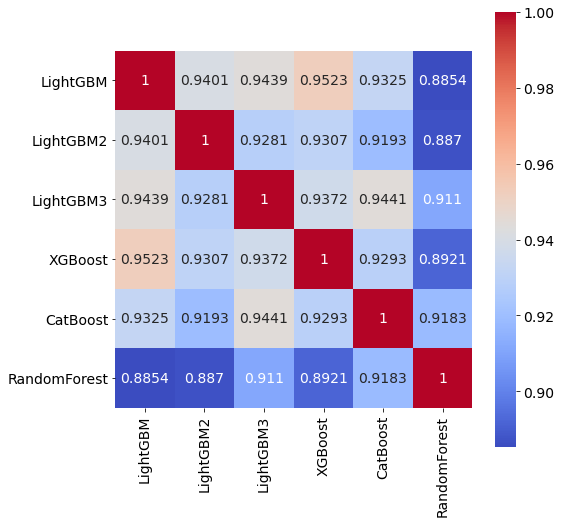

In [39]:
corr = scores.corr()

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr, annot=True, fmt='.4g', square=True, cmap='coolwarm', ax=axes)

scores.head()

#### LinearDiscriminantAnalysis

In [40]:
model_lda = LinearDiscriminantAnalysis(
    solver='eigen',
    shrinkage='auto',
    store_covariance=True,
    n_components=1
)

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=model_lda, 
                                                             X=scores, 
                                                             y=y, 
                                                             cv=folds)

Training fold 1, Test score: 0.74634
Training fold 2, Test score: 0.73565
Training fold 3, Test score: 0.73395
Training fold 4, Test score: 0.74161
Training fold 5, Test score: 0.72871
Training fold 6, Test score: 0.71791
Training fold 7, Test score: 0.73124
Training fold 8, Test score: 0.74864
Training fold 9, Test score: 0.74005
Training fold 10, Test score: 0.73338
Training fold 11, Test score: 0.73729
Training fold 12, Test score: 0.72976
Test mean score: 0.73538


#### LogisticRegression

In [41]:
model_lr = LogisticRegression(C=0.0005, solver='liblinear') 

estimators_lr, oof_preds_lr, mean_score = cross_validation(model=model_lr, 
                                                             X=scores, 
                                                             y=y, 
                                                             cv=folds)

Training fold 1, Test score: 0.74739
Training fold 2, Test score: 0.73673
Training fold 3, Test score: 0.73310
Training fold 4, Test score: 0.74112
Training fold 5, Test score: 0.72781
Training fold 6, Test score: 0.71763
Training fold 7, Test score: 0.73161
Training fold 8, Test score: 0.74763
Training fold 9, Test score: 0.74064
Training fold 10, Test score: 0.73310
Training fold 11, Test score: 0.73725
Training fold 12, Test score: 0.72900
Test mean score: 0.73525


#### VotingClassifier

In [42]:
model_vc = VotingClassifier(estimators=[('LogisticRegression', model_lr), ('LinearDiscriminantAnalysis', model_lda)], voting='soft')

estimators_vc, oof_preds_vc, mean_score = cross_validation(model=model_vc, 
                                                             X=scores, 
                                                             y=y, 
                                                             cv=folds)

Training fold 1, Test score: 0.74644
Training fold 2, Test score: 0.73567
Training fold 3, Test score: 0.73396
Training fold 4, Test score: 0.74153
Training fold 5, Test score: 0.72864
Training fold 6, Test score: 0.71790
Training fold 7, Test score: 0.73133
Training fold 8, Test score: 0.74855
Training fold 9, Test score: 0.74014
Training fold 10, Test score: 0.73337
Training fold 11, Test score: 0.73718
Training fold 12, Test score: 0.72964
Test mean score: 0.73536


### Result

In [43]:
TARGET = 'TARGET'
COLUMN_ID = 'APPLICATION_NUMBER'
test_index = test_df[COLUMN_ID]

In [44]:
test = test_df.drop(['APPLICATION_NUMBER'], axis=1)

In [45]:
# LightGBM
pred_lgb = model_lgb.predict(test)
pred_lgb2 = model_lgb2.predict(test)
pred_lgb3 = model_lgb3.predict(test)

# XGBoost
categorical_engineering(test)
pred_xgb = model_xgb.predict(test)

# CatBoost
pred_cb = model_cb.predict(test)

# RandomForest
test.replace([np.inf, -np.inf], np.nan, inplace=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0) 
imp = imp.fit(test)
test_imp = imp.transform(test)
pred_rfr = model_rfr.predict(test_imp)

In [46]:
test_scores = pd.DataFrame({
    'LightGBM': pred_lgb,
    'LightGBM2': pred_lgb2,
    'LightGBM3': pred_lgb3,
    'XGBoost': pred_xgb,
    'CatBoost': pred_cb,
    'RandomForest': pred_rfr
})

,LightGBM,LightGBM2,LightGBM3,XGBoost,CatBoost,RandomForest
0,0.07206,0.05066,0.07222,0.08827,0.09680,0.08141
1,0.26385,0.26585,0.21515,0.27304,0.24308,0.19937
2,0.14411,0.15438,0.16590,0.19272,0.21019,0.15333
3,0.08338,0.08375,0.08313,0.08519,0.08351,0.09407
4,0.01183,0.01970,0.01507,0.01347,0.00435,0.02762


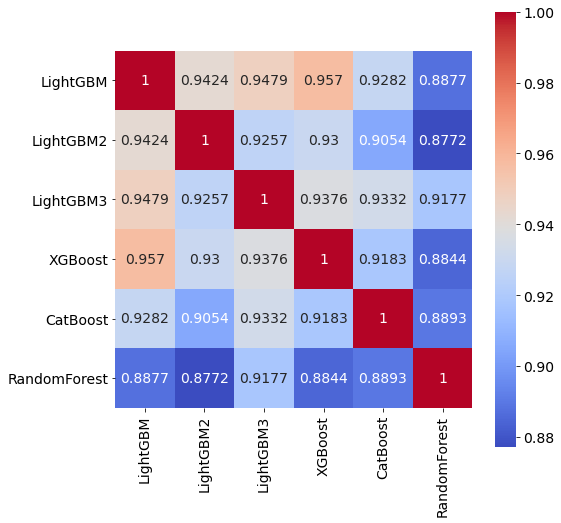

In [47]:
test_corr = test_scores.corr()

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(test_corr, annot=True, fmt='.4g', square=True, cmap='coolwarm', ax=axes)

test_scores.head()

In [48]:
# LinearDiscriminantAnalysis
prediction_lda = np.zeros(test.shape[0])
for model in estimators_lda:
    prediction_lda += model.predict_proba(test_scores)[:, 1]
prediction_lda = prediction_lda/len(estimators_lda)

In [49]:
# LogisticRegression
prediction_lr = np.zeros(test.shape[0])
for model in estimators_lr:
    prediction_lr += model.predict_proba(test_scores)[:, 1]
prediction_lr = prediction_lr/len(estimators_lr)

In [50]:
# VotingClassifier
prediction_vc = np.zeros(test.shape[0])
for model in estimators_vc:
    prediction_vc += model.predict_proba(test_scores)[:, 1]
prediction_vc = prediction_vc/len(estimators_vc)

In [51]:
submission['TARGET'] = prediction_lda
# submission['TARGET'] = prediction_lr
# submission['TARGET'] = prediction_vc

In [52]:
submission['TARGET'] = (prediction_lda*0.50) + (submission2['TARGET']*0.50) 

In [53]:
submission.to_csv('submission.csv', index=False)

In [54]:
submission.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.04369
1,123456549,0.47496
2,123428178,0.14084
3,123619984,0.05657
4,123671104,0.02091
